In [5]:
import numpy as np

In [337]:
class QPM_matrix:
    def params(self,mock_no,shot_noise_rescale,mean):
        self.mock_no=mock_no
        infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Covariances/Mock_%d/'%mock_no
        if mean:
            infile_root='/mnt/store1/oliverphilcox/CMU/QPM_Covariances/Mean/'
        self.n=36
        self.m=10
        self.n_indiv=10
        self.a=shot_noise_rescale
        self.r_bins = np.loadtxt('../../python/binfile_linear.csv')
    def read_all_matrices(self,root='full'):
        cov_root = infile_root+'CovMatricesAll/'
        c2=cov_root+'c2_n%d_m%d_11_%s.txt'%(self.n,self.m,root)
        c3=cov_root+'c3_n%d_m%d_1,11_%s.txt'%(self.n,self.m,root)
        c4=cov_root+'c4_n%d_m%d_11,11_%s.txt'%(self.n,self.m,root)
        c_tot=np.diag(np.loadtxt(c2))*self.a**2.+np.loadtxt(c3)*self.a+np.loadtxt(c4)
        return (c_tot+c_tot.T)/2.
    def read_jack_matrices(self,root='full'):
        print("ADD CXJ TERMS")
        cov_root = infile_root+'CovMatricesJack/'
        c2=cov_root+'c2_n%d_m%d_11_%s.txt'%(self.n,self.m,root)
        c3=cov_root+'c3_n%d_m%d_1,11_%s.txt'%(self.n,self.m,root)
        c4=cov_root+'c4_n%d_m%d_11,11_%s.txt'%(self.n,self.m,root)
        c_jack_tot=np.diag(np.loadtxt(c2))*self.a**2.+np.loadtxt(c3)*self.a+np.loadtxt(c4)
        return (c_jack_tot+c_jack_tot.T)/2.
    def compute_eigenvalues(self):
        self.eigval=np.linalg.eigvalsh(self.c_tot)
        self.eigvalJ = np.linalg.eigvalsh(self.c_jack_tot)
    def reduce_matrix(self):
        self.reduced_matrix=np.zeros_like(self.c_tot)
        for aa in range(len(self.reduced_matrix)):
            for bb in range(len(self.reduced_matrix[0])):
                self.reduced_matrix[aa,bb]=self.c_tot[aa,bb]/np.sqrt(self.c_tot[aa,aa]*self.c_tot[bb,bb])
    def compute_D_est(self):
        c_tot_mats=[]
        for i in range(self.n_indiv):
            c_tot_mats.append(self.read_all_matrices(root=str(i)))
        nn = len(c_tot_mats)
        summ=0.
        for i in range(nn):
            c_excl_i = np.mean(c_tot_mats[:i]+c_tot_mats[i+1:],axis=0)
            summ+=np.matmul(np.linalg.inv(c_excl_i),c_tot_mats[i])
        self.D_est = (nn-1.)/nn*(-1.*np.eye(len(self.c_tot))+1./nn*summ)
    def compute_precision(self):
        if not hasattr(self,'D_est'):
            self.compute_D_est()
        self.prec = np.matmul((np.identity(len(self.D_est))-self.D_est),np.linalg.inv(self.c_tot))
    def compute_N_eff(self):
        if not hasattr(self,'D_est'):
            self.compute_D_est()
        slogdetD=np.linalg.slogdet(self.D_est)
        n_bins = len(self.D_est)
        D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
        N_eff_D = (n_bins+1.)/D_value+1.
        print("Total N_eff Estimate: %.6e"%N_eff_D)
    def reduce_precision(self):
        if not hasattr(self,'prec'):
            self.compute_precision()
        self.red_prec=np.zeros_like(self.c_tot)
        for aa in range(len(self.red_prec)):
            for bb in range(len(self.red_prec[0])):
                self.red_prec[aa,bb]=self.prec[aa,bb]/np.sqrt(self.prec[aa,aa]*self.prec[bb,bb])
    def __init__(self, mock_no,shot_noise_rescale,mean=False):
        self.params(mock_no,shot_noise_rescale,mean)
        self.c_tot=self.read_all_matrices()
        self.c_jack_tot=self.read_jack_matrices()


import matplotlib.pyplot as plt
import cmocean

class plotting_tools:
    def __init__(self):
        self.FS=16
    def general_plotter(self,matrix,bin_min=None,bin_max=None,title=None):
        vmax=np.percentile(matrix.ravel(),99.9)
        plt.matshow(matrix,vmax=vmax,vmin=-vmax,cmap=cmocean.cm.balance)
        plt.ylabel('Bin ID b',fontsize=self.FS);
        plt.xlabel('Bin ID a',fontsize=self.FS);
        plt.gca().xaxis.tick_bottom()
        plt.xlim([bin_min,bin_max])
        plt.ylim([bin_max,bin_min])
        plt.title(title,fontsize=self.FS+4)
        plt.colorbar();
    def plot_covariance(self,matrix_class,bin_min=None,bin_max=None):
        self.general_plotter(matrix_class.c_tot,bin_min=bin_min,bin_max=bin_max,title=r'$C_{ab}$')
    def plot_reduced_covariance(self,matrix_class,bin_min=None,bin_max=None):
        matrix_class.reduce_matrix()
        self.general_plotter(matrix_class.reduced_matrix,bin_min=bin_min,bin_max=bin_max,title=r'Reduced $C_{ab}$')
    def plot_precision(self,matrix_class,bin_min=None,bin_max=None):
        matrix_class.compute_precision()
        self.general_plotter(matrix_class.prec,bin_min=bin_min,bin_max=bin_max,title=r'$\psi_{ab}$')
    def plot_reduced_precision(self,matrix_class,bin_min=None,bin_max=None):
        matrix_class.compute_precision()
        matrix_class.reduce_precision()
        self.general_plotter(matrix_class.red_prec,bin_min,bin_max,title=r'Reduced $\psi_{ab}$')
    def plot_eigenvalues(self,matrix_class):
        matrix_class.compute_eigenvalues()
        plt.plot(matrix_class.eigval,label='Full Matrix');
        plt.ylabel('Eigenvalue',fontsize=self.FS);plt.xlabel('Index',fontsize=self.FS)
        plt.plot(matrix_class.eigvalJ,label='Jackknife Matrix')
        plt.legend(fontsize=self.FS-4.);
        plt.yscale('log');

In [338]:
qpm=QPM_matrix(0,1.00,mean=True)

ADD CXJ TERMS


In [342]:
qpm.compute_N_eff()
qpm.compute_precision()

Total N_eff Estimate: 5.488125e+04


In [328]:
precs=[]
for i in range(10):
    qpm=QPM_matrix(i,1.0)
    qpm.compute_N_eff()
    qpm.compute_precision()
    precs.append(qpm.prec)

ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04
ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04
ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04
ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04
ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04
ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04
ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04
ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04
ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04
ADD CXJ TERMS
Total N_eff Estimate: 5.488125e+04


In [343]:
precs[0]-qpm.prec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

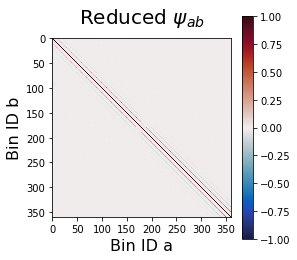

In [321]:
pt=plotting_tools()
pt.plot_reduced_precision(qpm)#,50,100)

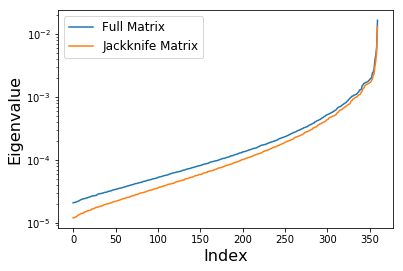

In [322]:
pt=plotting_tools()
pt.plot_eigenvalues(qpm)